# Part 2: Model Construction
We will be using two ensemble methods and one boosted classifier to attempt modeling our customer churn data. First, we will use Logistic Regression, then Random Forests, and finally using an AdaBoosted classifier. The notebook will conclude with an assessment of completed models and selection of a final model. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB,ComplementNB
from sklearn.feature_selection import SelectKBest
import joblib


from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support,f1_score,fbeta_score
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix, recall_score, make_scorer
from sklearn.linear_model import LogisticRegression 
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import classification_report

df = pd.read_csv('Data\cleaned_data.csv')

#we remove extra index

df = df.drop(columns = 'Unnamed: 0')

df.head()

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  depreca

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn,total_charge
0,KS,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0,75.56
1,OH,107,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0,59.24
2,NJ,137,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0,62.29
3,OH,84,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0,66.80
4,OK,75,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0,52.09


Before we start the process of constructing our model, it would help to know when we will know we are finished! Otherwise we would be beginning a race without knowing where the finish line is, which is no way to work. 
For SyriaTel, we will be prioritizing recall when evaluating the performance of models. This is because it is more important to capture all customers at risk of churn than it is to avoid classifying those not going to churn incorrectly. Put simply, SyriaTel will not mind being 'better safe than sorry' when classifying at-risk customers. 

## Constructing a Correlation Matrix

<AxesSubplot:>

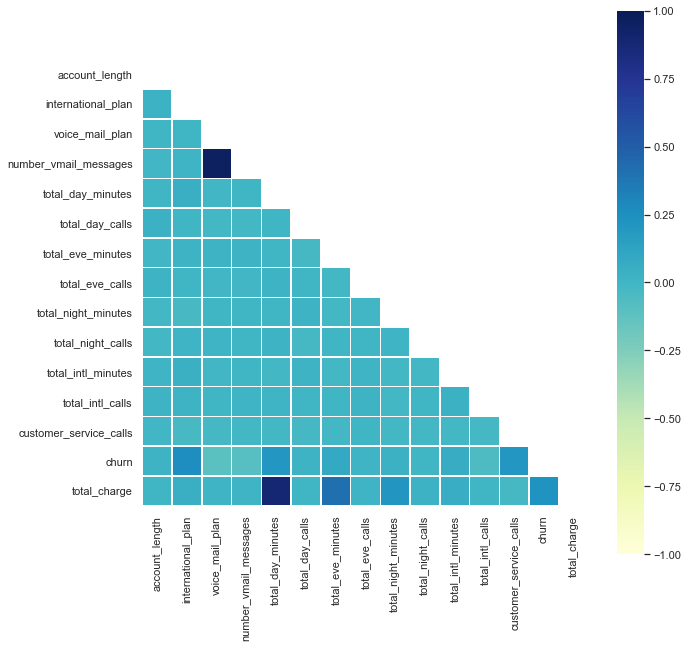

In [2]:
# we plot a correlation matrix

sns.set(style = 'white')

corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype = np.bool))

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10))

sns.heatmap(corr, mask = mask, cmap = "YlGnBu", center = 0, vmax = 1, vmin = -1, square = True, linewidths = 0.5)

In [3]:
# we drop 'number_vmail_messages' due to high multicollinearity

df = df.drop('number_vmail_messages', axis = 1)

<AxesSubplot:>

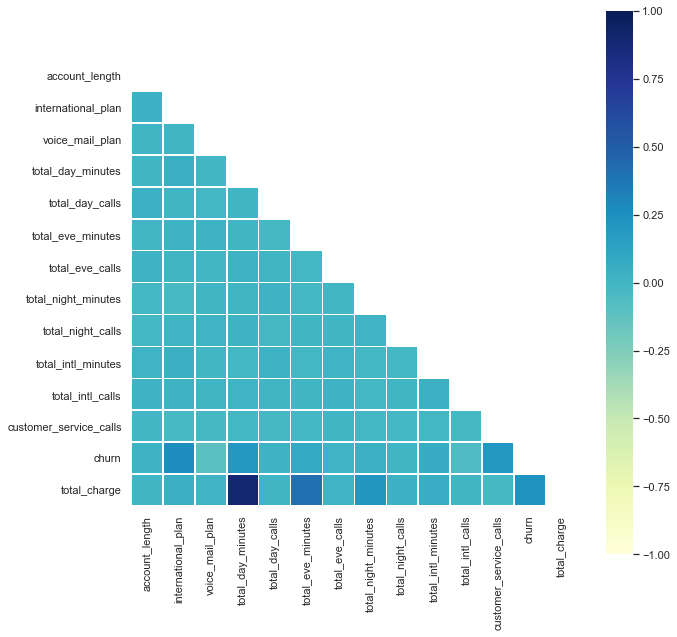

In [4]:
sns.set(style = 'white')

corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype = np.bool))

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10))


sns.heatmap(corr, mask = mask, cmap = "YlGnBu", vmax = 1, vmin = -1, center = 0, square = True, linewidths = 0.5)

# Modelling

In [5]:
# we define functions to be used in modeling

def get_xy(df, drops, target):
    X = df.drop(columns = drops)
    X = df.drop(columns = target)
    y = df[target]
    return X, y

def drop_cols(df, columns):
    for col in columns:
        if col in df.columns:
            df.drop(columns = col, inplace = True)
        if col in catts:
            catts.remove(col)
        if col in numms:
            numms.remove(col)
        else:
            pass

## Logistic Regression Classifier
### Simple Logistic Regression

In [6]:
# we address 'state' categorical column

df_logreg = pd.get_dummies(df)
df_logreg.columns

Index(['account_length', 'international_plan', 'voice_mail_plan',
       'total_day_minutes', 'total_day_calls', 'total_eve_minutes',
       'total_eve_calls', 'total_night_minutes', 'total_night_calls',
       'total_intl_minutes', 'total_intl_calls', 'customer_service_calls',
       'churn', 'total_charge', 'state_AK', 'state_AL', 'state_AR', 'state_AZ',
       'state_CA', 'state_CO', 'state_CT', 'state_DC', 'state_DE', 'state_FL',
       'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN',
       'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME',
       'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC',
       'state_ND', 'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV',
       'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI',
       'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA',
       'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY'],
      dtype='object'

In [7]:
# we define X, y, and split

X, y = get_xy(df_logreg, drops = [], target = 'churn')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 10)

#### SMOTE

In [8]:
# we check for class imbalances and find an imbalance of 1:6

df['churn'].value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [9]:
# we establish smote

smote = SMOTE()

In [10]:
# we manufacture data to balance classes and verify

X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

y_train_smote_counter = Counter(y_train_sm)

y_train_sm.sum() / len(y_train_sm)

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.5

In [11]:
# we establish and fit our initial logistic regression

logreg = LogisticRegression(fit_intercept = False, max_iter = 500, solver = 'liblinear')
logistic_model = logreg.fit(X_train_sm, y_train_sm)
logistic_model

LogisticRegression(fit_intercept=False, max_iter=500, solver='liblinear')

In [12]:
# we generate predictions

y_test_predictions = logreg.predict(X_test)
y_train_predictions = logreg.predict(X_train_sm)

In [13]:
logistic_model.score(X_train_sm, y_train_sm), logistic_model.score(X_test, y_test)

(0.7720314439387671, 0.762)

Text(0.5, 1.0, 'Simple Logistic Regression')

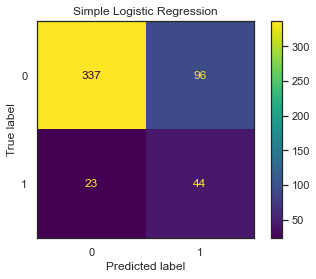

In [14]:
# we visualize our confusion matrix, taking note of False Negatives above all else. 

plot_confusion_matrix(logistic_model, X_test, y_test)
plt.title('Simple Logistic Regression')

In [15]:
# we compute our validation metric, recall

print('Our Training Recall Score: ' , recall_score(y_train_sm, y_train_predictions))
print('Our Testing Recall Score: ' , recall_score(y_test, y_test_predictions))

Our Training Recall Score:  0.7823748448489863
Our Testing Recall Score:  0.6567164179104478


### Conclusions on Simple Logistic Regression
* With a score less than 85%, this model can't be said to perform well.
* Furthermore, our testing score is sufficiently distant from our training score that our model is not consistent. 


## Logistic Regression using GridSearchCV

In [16]:
# we establish another model and a parameter dictionary for use in GridSearch

logreg = LogisticRegression()

parameters = {
    "penalty": ['l1', 'l2'],
    "fit_intercept": [True, False],
    "max_iter": [100, 200, 300],
    "C": [0.25, 0.5, 1.0, 2.0, 5.0, 10.0],
    'solver': ['liblinear']}

In [17]:
# we establish our GridSearch and prioritize recall through 'scoring' parameter

gridsearch_cv = GridSearchCV(logreg, param_grid = parameters, n_jobs = -1, verbose = 2, scoring = make_scorer(recall_score))

In [18]:
# we fit our GridSearch using balanced data

gridsearch_cv.fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   23.4s finished


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.25, 0.5, 1.0, 2.0, 5.0, 10.0],
                         'fit_intercept': [True, False],
                         'max_iter': [100, 200, 300], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring=make_scorer(recall_score), verbose=2)

In [19]:
# we print our results dataframe

gridsearch_results = pd.DataFrame(gridsearch_cv.cv_results_)

gridsearch_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_fit_intercept,param_max_iter,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.132075,1.056888,0.003591,4.886752e-04,0.25,True,100,l1,liblinear,"{'C': 0.25, 'fit_intercept': True, 'max_iter':...",0.757764,0.807453,0.816116,0.863636,0.821946,0.813383,0.033867,4
1,0.037982,0.001874,0.001497,1.000023e-03,0.25,True,100,l2,liblinear,"{'C': 0.25, 'fit_intercept': True, 'max_iter':...",0.749482,0.786749,0.799587,0.857438,0.830228,0.804697,0.036960,40
2,3.933214,0.553628,0.001197,3.989221e-04,0.25,True,200,l1,liblinear,"{'C': 0.25, 'fit_intercept': True, 'max_iter':...",0.757764,0.807453,0.816116,0.863636,0.821946,0.813383,0.033867,4
3,0.036604,0.001072,0.001196,3.967287e-04,0.25,True,200,l2,liblinear,"{'C': 0.25, 'fit_intercept': True, 'max_iter':...",0.749482,0.786749,0.799587,0.857438,0.830228,0.804697,0.036960,40
4,3.977500,0.432542,0.000998,3.371748e-07,0.25,True,300,l1,liblinear,"{'C': 0.25, 'fit_intercept': True, 'max_iter':...",0.757764,0.807453,0.816116,0.863636,0.821946,0.813383,0.033867,4


In [20]:
# we find and score the optimal model 

best_logreg = gridsearch_cv.best_estimator_

best_logreg.score(X_train_sm, y_train_sm), best_logreg.score(X_test, y_test)

(0.8080264791063302, 0.774)

Text(0.5, 1.0, 'GridSearchCV Logistic Regression')

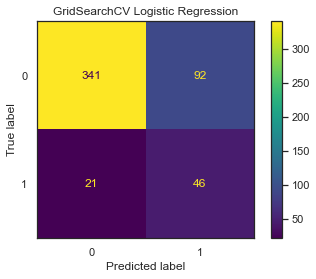

In [21]:
# we plot another confusion matrix

plot_confusion_matrix(best_logreg, X_test, y_test)
plt.title('GridSearchCV Logistic Regression')

In [22]:
gridsearch_test_predictions = best_logreg.predict(X_test)
gridsearch_train_predictions = best_logreg.predict(X_train_sm)

In [23]:
print("Logistic Regression Gridsearch Training Recall Score: ", recall_score(y_train_sm, gridsearch_train_predictions))
print("Logistic Regression Gridsearch Testing Recall Score: ", recall_score(y_test, gridsearch_test_predictions))

Logistic Regression Gridsearch Training Recall Score:  0.8204385601985933
Logistic Regression Gridsearch Testing Recall Score:  0.6865671641791045


### Conclusions on Logistic Regression using GridSearch
* While our score has increased, we are still not above the 85% recall mark we set for ourselves to accept a model's validity. 
* Our training and testing scores are still distant, resulting in model inconsistency. 

# Random Forest Classifier

In [24]:
# we establish a fresh dataframe for our random forest

df_forest = pd.get_dummies(df)

In [25]:
# we split our dataframe into training and validation sets

training_df, validation_df = train_test_split(df_forest, test_size = 0.15)

In [26]:
# we establish our Random Forest and a parameter grid

rfclf = RandomForestClassifier()
parameters = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [1, 3, 5, 8, 10]
}

In [27]:
# we establihs our GridSearch, again prioritizing recall 

gridsearch_cv = GridSearchCV(rfclf, param_grid = parameters, n_jobs = -1, verbose = 2, scoring = make_scorer(recall_score))

In [28]:
# we split our training dataframes into predictors and targets

X_train, y_train = get_xy(training_df, drops = [], target = 'churn')
X_validation, y_validation = get_xy(validation_df, drops = [], target = 'churn')

In [29]:
# we fit our GridSearch

gridsearch_cv.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 8, 10],
                         'n_estimators': [10, 20, 50, 100]},
             scoring=make_scorer(recall_score), verbose=2)

In [30]:
# we view our GridSearch Results

gs_results_df = pd.DataFrame(gridsearch_cv.cv_results_)
gs_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.020200,0.000747,0.004494,0.000452,1,10,"{'max_depth': 1, 'n_estimators': 10}",0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.00000,17
1,0.036881,0.002413,0.005195,0.000407,1,20,"{'max_depth': 1, 'n_estimators': 20}",0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.00000,17
2,0.081480,0.006783,0.009413,0.001202,1,50,"{'max_depth': 1, 'n_estimators': 50}",0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.00000,17
3,0.158360,0.002799,0.012788,0.000745,1,100,"{'max_depth': 1, 'n_estimators': 100}",0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.00000,17
4,0.022487,0.000632,0.003995,0.000622,3,10,"{'max_depth': 3, 'n_estimators': 10}",0.108434,0.0,0.0,0.292683,0.02439,0.085101,0.11118,14


In [31]:
# we find and score our optimal Random Forest

best_random_forest = gridsearch_cv.best_estimator_
best_random_forest.score(X_train, y_train), best_random_forest.score(X_validation, y_validation)

(0.9805859512883869, 0.944)

Text(0.5, 1.0, 'Initial Random Forest')

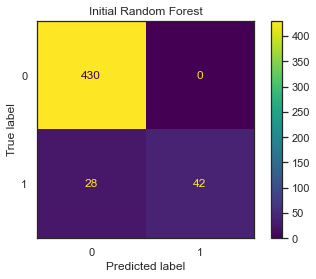

In [32]:
# we plot a confusion matrix for this model

plot_confusion_matrix(best_random_forest, X_validation, y_validation)
plt.title('Initial Random Forest')

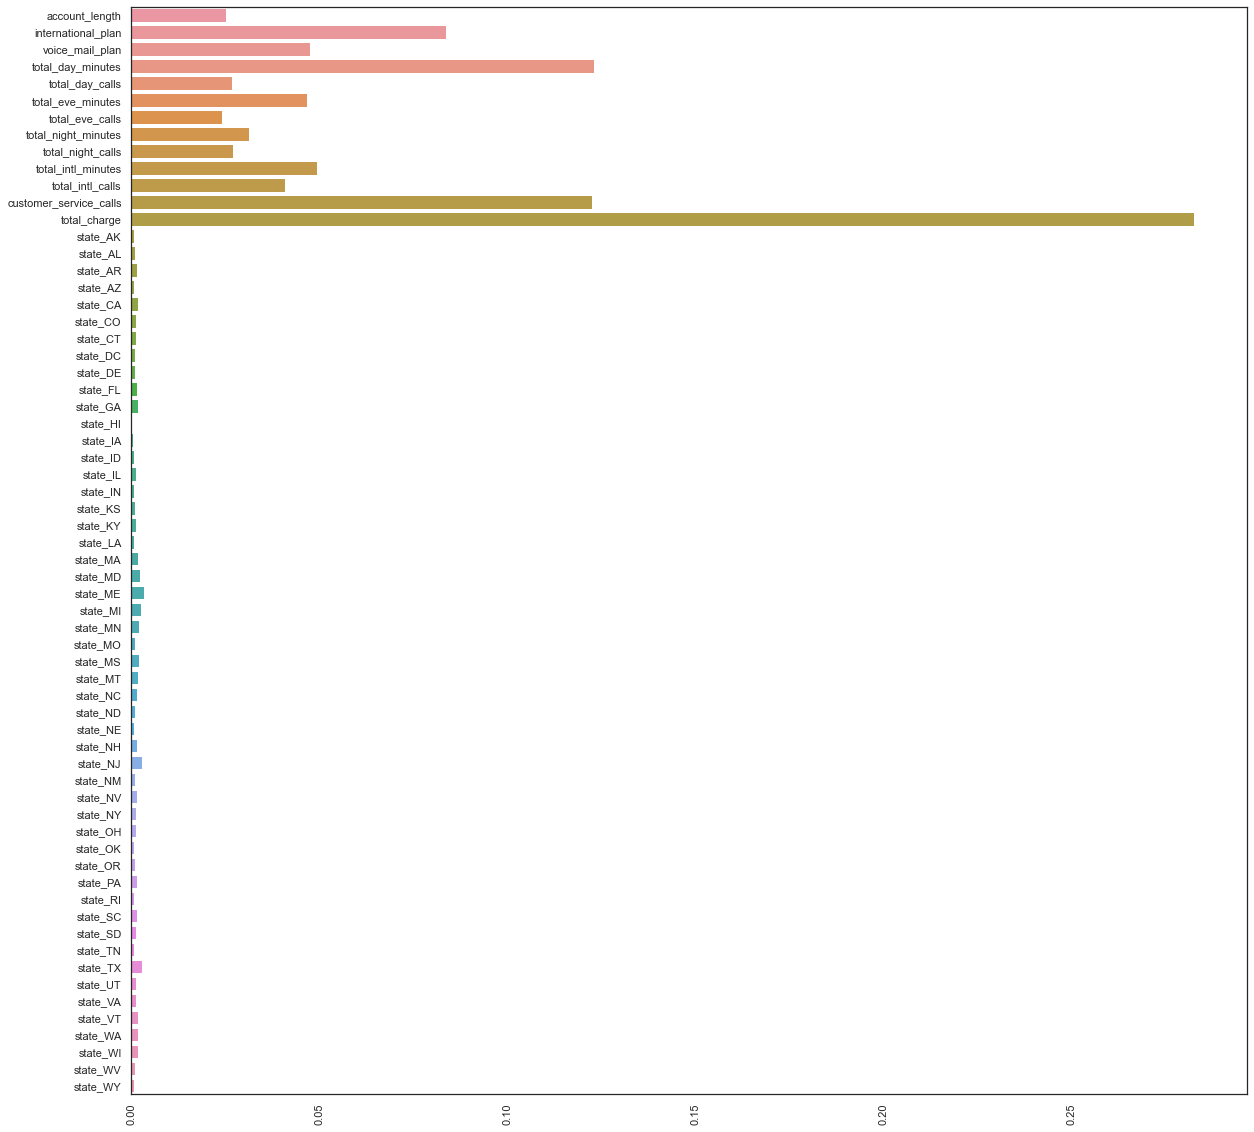

In [33]:
# we plot the feature importances for our best Random Forest

features = X_train.columns
feature_imports = best_random_forest.feature_importances_

plt.figure(figsize = (20, 20))
sns.barplot(y = features, x = feature_imports)
plt.xticks(rotation = 90)
plt.show()

[Text(0.5, 1.0, 'Location Predictors'), Text(0.5, 0, 'Importance')]

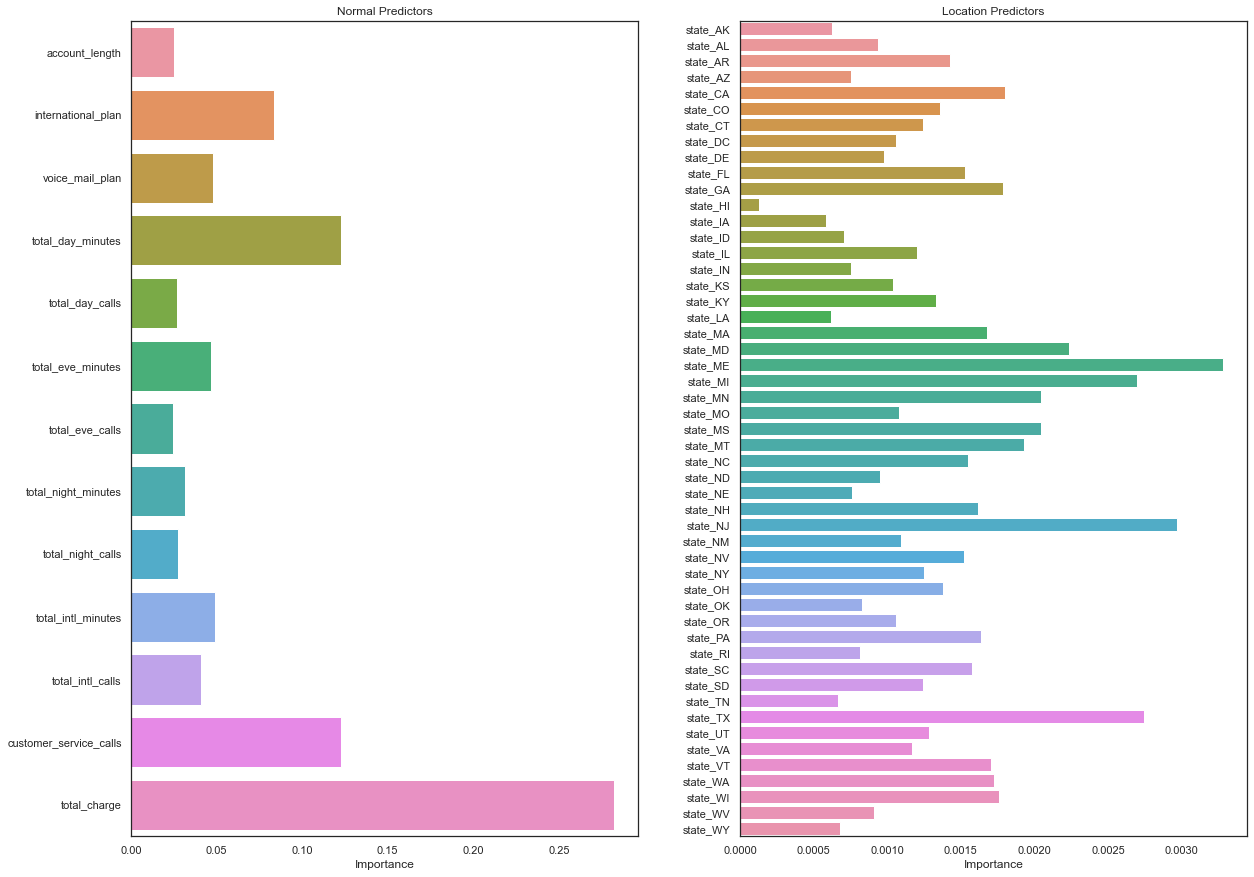

In [34]:
# for readaability, we seperate location predictors from other predictors. 


state_features = X_train.columns[-51:]
other_features = X_train.columns[0:13]
state_features


fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 15))

sns.barplot(ax = axes[0], y = other_features, x = feature_imports[0:13]).set(title = 'Normal Predictors', xlabel = "Importance")
sns.barplot(ax = axes[1], y = state_features, x = feature_imports[-51:]).set(title = 'Location Predictors', xlabel = "Importance")

In [35]:
# we score our final model

gridsearch_test_predictions = best_random_forest.predict(X_validation)
gridsearch_train_predictions = best_random_forest.predict(X_train)

In [36]:
print("Random Forest Gridsearch Training Recall Score: ", recall_score(y_train, gridsearch_train_predictions))
print("Random Forest Gridsearch Testing Recall Score: ", recall_score(y_validation, gridsearch_test_predictions))

Random Forest Gridsearch Training Recall Score:  0.8668280871670703
Random Forest Gridsearch Testing Recall Score:  0.6


### Conclusions on Initial Random Forest Ensemble
* While this is a great improvement over our logistic model, we still have the issue of the large difference between our Training and Testing score, suggesting model inconsistency. 
* Location features (the 'states' categories) play very little importance compared to other features, supported by our findings in EDA about churn by state. 
* We will drop location features to cut down on feature noise, as 'state' may be imparting undue influence on our model. 


In [37]:
# we make a fresh dataframe for the next forest

df_rf2 = df.copy()

In [38]:
# we drop the 'state' column

df_rf2 = df_rf2.drop(columns = 'state', axis = 1)

In [39]:
# we split our dataframe and establish our classifier and parameter grid

training_df, validation_df = train_test_split(df_rf2, test_size = 0.15)

rfclf = RandomForestClassifier()

parameters = {   
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [1, 3, 5, 8, 10]
}

In [40]:
# we establish our GridSearch

gridsearch_cv = GridSearchCV(rfclf, param_grid = parameters, n_jobs = -1, verbose = 2, scoring = make_scorer(recall_score))

In [41]:
# we establish our predictors and targets

X_train, y_train = get_xy(training_df, drops = [], target = 'churn')
X_validation, y_validation = get_xy(validation_df, drops = [], target = 'churn')

In [42]:
# we fit our GridSearch

gridsearch_cv.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  89 out of 100 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 8, 10],
                         'n_estimators': [10, 20, 50, 100]},
             scoring=make_scorer(recall_score), verbose=2)

In [43]:
# we view the GridSearch dataframe

gs_results_df = pd.DataFrame(gridsearch_cv.cv_results_)
gs_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.017148,0.000402,0.003590,0.000488,1,10,"{'max_depth': 1, 'n_estimators': 10}",0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,17
1,0.034508,0.002054,0.004787,0.000399,1,20,"{'max_depth': 1, 'n_estimators': 20}",0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,17
2,0.093350,0.009557,0.009574,0.003253,1,50,"{'max_depth': 1, 'n_estimators': 50}",0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,17
3,0.163562,0.010191,0.014162,0.001596,1,100,"{'max_depth': 1, 'n_estimators': 100}",0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,17
4,0.022539,0.001352,0.003989,0.000631,3,10,"{'max_depth': 3, 'n_estimators': 10}",0.253012,0.506024,0.409639,0.46988,0.349398,0.39759,0.089838,13


In [44]:
# we find and score the Random Forest

best_random_forest = gridsearch_cv.best_estimator_
best_random_forest.score(X_train, y_train), best_random_forest.score(X_validation, y_validation)

(0.9795270031768444, 0.988)

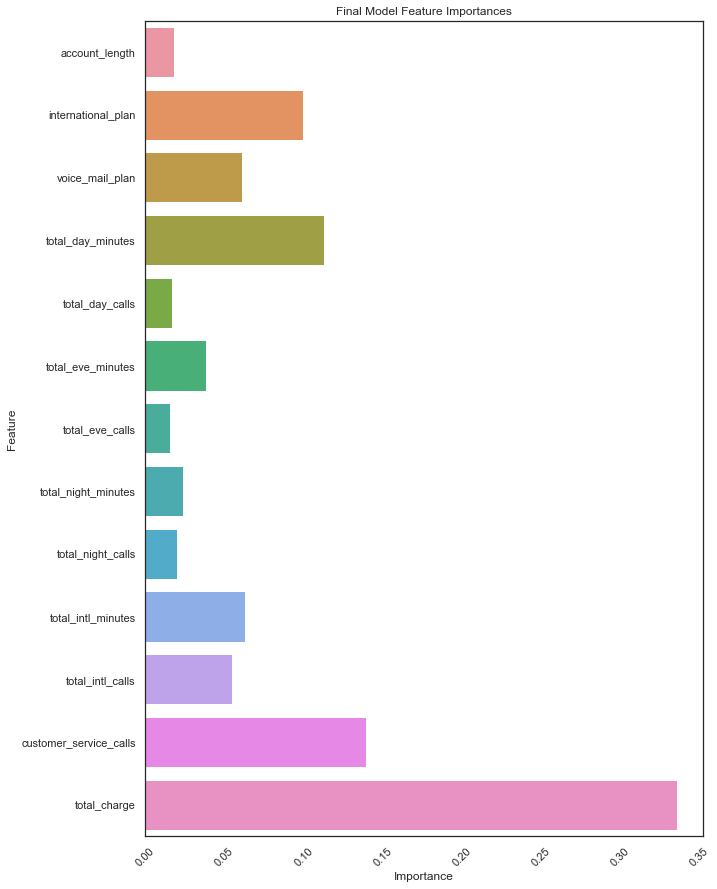

In [55]:
# we plot the feature importances

features = X_train.columns
feature_imports = best_random_forest.feature_importances_

plt.figure(figsize = (10, 15))
sns.barplot(y = features, x = feature_imports)
plt.xticks(rotation = 45)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Final Model Feature Importances')
plt.show()

Text(0.5, 1.0, 'Final RF Model Train')

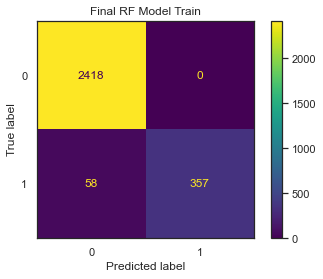

In [46]:
# we compare confusion matrices

plot_confusion_matrix(best_random_forest, X_train, y_train)
plt.title('Final RF Model Train')

Text(0.5, 1.0, 'Final RF Model Test')

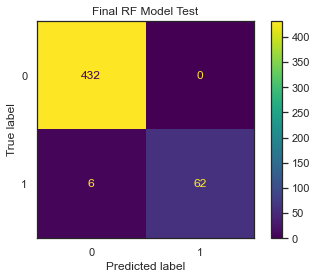

In [47]:
plot_confusion_matrix(best_random_forest, X_validation, y_validation)
plt.title('Final RF Model Test')

In [48]:
# we score our final model

gridsearch_test_predictions = best_random_forest.predict(X_validation)
gridsearch_train_predictions = best_random_forest.predict(X_train)

In [49]:
print("Random Forest Gridsearch Training Recall Score: ", recall_score(y_train, gridsearch_train_predictions))
print("Random Forest Gridsearch Testing Recall Score: ", recall_score(y_validation, gridsearch_test_predictions))

Random Forest Gridsearch Training Recall Score:  0.8602409638554217
Random Forest Gridsearch Testing Recall Score:  0.9117647058823529


# Cost Benefit Analyses

In [50]:
# we show how much gain/loss each possible outcome has. TP, TN, FP, FN

# true positives, customers who are going to churn and we spend to retain.
# looking for the cost benefit of retaining a customer who would've churned
# benefit = profit from customer - cost of retaining customer
# taking mean charge of all customer to be profit from customer
# cost of retaining customer is vague. Assumed to be 1/4 of mean charge
# as arbitrary cutoff

TP = df['total_charge'].mean() - df['total_charge'].mean() * 0.25

# true negatives, customers who are not going to churn, and we do not spend.
# looking for the cost of not spending on a customer who doesn't need it. 
# benefit/cost = 0

TN = 0

# false positives, customers who are not going to churn, and we spend to retain.
# looking for the cost of spending on customer who do not need it. 
# benefit = -(cost of retaining customer)

FP = -(df['total_charge'].mean() * 0.25)

# false negatives, customers who are going to churn, and we do not spend. 
# looking for cost of not spending on a customer who needs it. 
# cost = -(profit from customer)

FN = -(df['total_charge'].mean())

In [51]:
# we define a cost benefit analysis (sourced from study group) with custom
# cost weights shown by cb_dict

def cost_benefit_analysis(model, X_test, y_test):
    y_preds = model.predict(X_test)
    label_dict = {"TP":0, "FP": 0, "TN": 0, "FN": 0}
    for yt, yp in zip(y_test, y_preds):
        if yt==yp:
            if yt==1:
                label_dict["TP"] += 1
            else:
                label_dict["TN"] += 1
        else:
            if yp==1:
                label_dict["FP"] += 1
            else:
                label_dict["FN"] += 1
    cb_dict = {"TP": TP, "FP": FP, "TN": TN, "FN": FN}
    total = 0
    for key in label_dict.keys():
        total += cb_dict[key]*label_dict[key]
    return total / sum(label_dict.values())

In [52]:
print(cost_benefit_analysis(best_random_forest, X_validation, y_validation))

4.815430072007195


This metric shows that for every customer that we classify using our model, we will be saving 3.15. While on the individual level this is not much, if we multiply this by length of our dataset (3333) we get a total cost reclamation of 10,498 dollars! Remember that this is for one single month! 

# Models Used

## Final Model to be used

Because we were prioritizing recall from the start, we will be putting our final constructed model, a Random Forest Classifier which did not use location information to predict customer churn. 

# Conclusions

## Recommendations to business stakeholders

Our recommendations primarily come from our Exploratory Data Analysis in the 'Introduction and EDA' notebook in this repository. 



### 1. Investigate how our International Plan can be improved. 
* We found that of customers enrolled in the International Plan, 42% decided to leave SyriaTel. This suggests that customers are very displeased with our international service. 
* We also found that international service subscribers pay roughly the same amount for international calls than their non-enrolled counterparts. Giving these subscribers a greater discount on international calls may improve our international plan performance, contributing to greater customer retention. 



### 2. Continue attempting campaigns!
* We found that a promotional campaign was underway during the time period our data was collected on. This was inferred based on the bimodal distribution of churned customers' total charges, and the slightly right skewed distribution of account length. The relationship between these two predictors suggests that the campaign was for new customers who enjoyed a discount for an introductory period. 
* While this campaign contributes to churn once this intro period is over, it is better to "take two steps forward and one step back" in this scenario. 
* Some campaigns to consider, based upon feature importance of our final model:
    - Offer at-risk customers a **trial voicemail plan**. From our EDA, customers are much less likely to churn if they are subscribed in this plan. 
    - Offer at-risk customers a **discount on their monthly charge**. While this is somewhat obvious, total charge was the single greatest feature in our final model and should not be understated. 
    - Offer **loyalty rewards** to customers with history with SyriaTel. This will help protect SyriaTel from campaigns of competing companies who may be offering our customers introductory offers (as we should be doing to their customers as well!)

### 3. Improve our Customer Service Experience
- We found that the number of customer service calls a subsciber has to make is the second greatest feature in importance. While it is more difficult to make a customer happier with their monthly bill without taking a direct hit to profits, improving a customer's experience with our staff is not difficult to imnprove. We can accomplish this by:
    - Prioritizing the minimization of customer service calls through agent responsibility. Any customer that needs to call more than 5 times in one single cycle is not having their needs met by our service agents. These situations must be addressed sooner before our customer decides to leave on the basis of bad customer service. 
    - Providing alternatives to our customers to manage their accounts. We can add mobile, online, or automated phone accessibility quite easily, and the more self-service a customer can accomplish will decrease the burden upon our service agents as well as the need for their expert assistance. 

## Further research for improvement

SyriaTel's next step is to put these campaigns and service improvements into effect. Once this is done, we will be completing another investigation to see how effective these campaings were, which will further validate or invalidate the model we have constructed. 